# Developer Salary Prediction - Udacity ML Project

This project applies the CRISP-DM methodology to analyze and predict developer salaries using the 2023 Stack Overflow Developer Survey.

---



## Section 1: Business Understanding

**Goal**: Predict the annual salary (`ConvertedCompYearly`) of developers based on demographics and experience.

**Why it matters**: Understanding the factors that influence developer salaries can help:
- Developers make informed career choices
- HR and recruiters design better offers
- Companies improve talent retention

### Business Questions:
1. How does years of professional coding experience impact salary?
2. Does education level significantly influence salary?
3. Are remote developers paid more?

We aim to answer these using descriptive statistics, visualization, and regression modeling.


In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("survey_results_public.csv")

# Initial data preview
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (65437, 114)


,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN




## Section 2: Data Understanding

We use the [Stack Overflow Developer Survey](https://survey.stackoverflow.co/datasets/stack-overflow-developer-survey-2024.zip), which contains over 65,000 responses from developers worldwide.

### Key Columns of Interest:

- `ConvertedCompYearly`: Annual salary (target)
- `YearsCodePro`: Years of professional coding experience
- `EdLevel`: Education level
- `RemoteWork`: Remote or in-person status
- `Employment`: Current employment status
- `Country`: Country of residence
- `LanguageHaveWorkedWith`: Languages the respondent has used

We will begin by inspecting the structure, types, and missing values.


In [3]:
# Check data types and missing values
df.info()

# Quick view of some rows
df.sample(5)

# Check nulls in selected columns
cols_of_interest = [
    "ConvertedCompYearly", "YearsCodePro", "EdLevel",
    "RemoteWork", "Employment", "Country", "LanguageHaveWorkedWith"
]
df[cols_of_interest].isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65437 entries, 0 to 65436
Columns: 114 entries, ResponseId to JobSat
dtypes: float64(13), int64(1), object(100)
memory usage: 56.9+ MB


ConvertedCompYearly       42002
YearsCodePro              13827
EdLevel                    4653
RemoteWork                10631
Employment                    0
Country                    6507
LanguageHaveWorkedWith     5692
dtype: int64



## Section 3: Data Preparation

### Step 1: Keep only relevant columns

To simplify the analysis and improve model performance, we filter the dataset to include only the most impactful columns.

### Step 2: Handle Missing Values

We clean missing values using the following approach:

- **ConvertedCompYearly**: Drop rows where salary is missing or zero. These values are not useful for modeling.
- **YearsCodePro**: Fill missing with `"0"` assuming no professional experience.
- **LanguageHaveWorkedWith** and **RemoteWork**: Fill missing with `"Unknown"` to retain rows without bias.

### Justification

- Dropping salary rows avoids corrupt targets during training.
- Using `"0"` for missing experience assumes they're new developers, which is conservative.
- For categorical values, `"Unknown"` helps preserve sample size without distortion.

This approach balances data retention with modeling quality.


In [4]:
# Select relevant columns
df_model = df[[
    "ConvertedCompYearly", "YearsCodePro", "EdLevel",
    "RemoteWork", "Employment", "Country", "LanguageHaveWorkedWith"
]].copy()

# Drop rows with missing or 0 salary
df_model = df_model[df_model["ConvertedCompYearly"].notnull()]
df_model = df_model[df_model["ConvertedCompYearly"] > 0]

# Fill missing values
df_model["YearsCodePro"] = df_model["YearsCodePro"].fillna("0")
df_model["LanguageHaveWorkedWith"] = df_model["LanguageHaveWorkedWith"].fillna("Unknown")
df_model["RemoteWork"] = df_model["RemoteWork"].fillna("Unknown")

# Check for remaining nulls
df_model.isnull().sum()

ConvertedCompYearly       0
YearsCodePro              0
EdLevel                   0
RemoteWork                0
Employment                0
Country                   0
LanguageHaveWorkedWith    0
dtype: int64

---

## Section 4: Data Modeling

To estimate developer salaries, we use a **Random Forest Regressor**, a model that works well for both linear and non-linear relationships.

### 🔢 Modeling Steps

1. Encode categorical variables using One-Hot Encoding.
2. Split data into training and testing sets.
3. Train a Random Forest model on the training set.
4. Evaluate performance using:
   - Mean Absolute Error (MAE)
   - Root Mean Squared Error (RMSE)
   - R² Score

We define the following reusable function for training and evaluation:


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def train_salary_model(df, target_column="ConvertedCompYearly"):
    """
    Trains a Random Forest Regressor model to predict developer salaries.

    Parameters:
    df (DataFrame): The input dataframe containing features and the target column.
    target_column (str): The name of the target column to predict. Default is "ConvertedCompYearly".

    Returns:
    model (RandomForestRegressor): The trained regression model.
    metrics (dict): Dictionary containing MAE, RMSE, and R2 Score on test data.
    """
    X = df.drop(columns=[target_column])
    y = df[target_column]

    X_encoded = pd.get_dummies(X, drop_first=True)
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    metrics = {
        "MAE": round(mean_absolute_error(y_test, y_pred), 2),
        "RMSE": round(np.sqrt(mean_squared_error(y_test, y_pred)), 2),
        "R2 Score": round(r2_score(y_test, y_pred), 4)
    }

    return model, metrics


# Sample 5000 rows for faster training
df_sample = df_model.sample(n=5000, random_state=42)

# Train the model
model, evaluation_results = train_salary_model(df_model)

# Get encoded feature columns for prediction
X = df_model.drop(columns=["ConvertedCompYearly"])
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, _, _, _ = train_test_split(X_encoded, df_model["ConvertedCompYearly"], test_size=0.2, random_state=42)


## Section 5: Evaluation and Scenario Prediction

Evaluate model performance and demonstrate its use with a hypothetical developer profile.

### Print Model Performance

In [6]:
# Display evaluation results
print("📊 Model Performance Metrics:")
for metric, value in evaluation_results.items():
    print(f"{metric}: {value}")


📊 Model Performance Metrics:
MAE: 34137.72
RMSE: 87113.57
R2 Score: 0.1905


### Visualize Salary by Experience

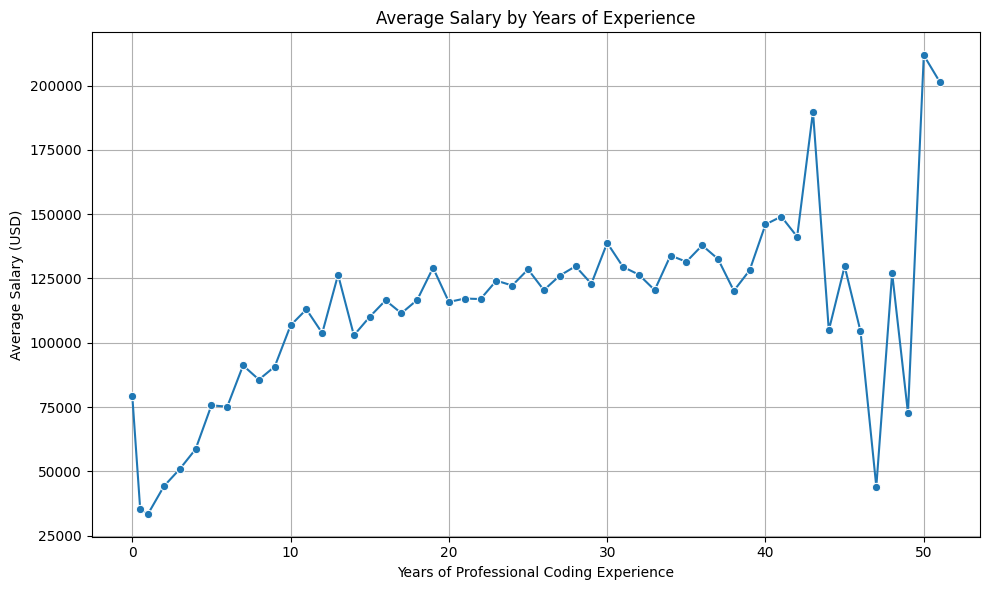

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean and convert 'YearsCodePro' to float
def convert_years(code):
    """
    Converts coding experience text into numerical years.

    Parameters:
    code (str): Text description of years of experience.

    Returns:
    float or None: Numeric representation of years (e.g., 0.5 for 'Less than 1 year', 51 for 'More than 50 years').
    """
    if code == "Less than 1 year":
        return 0.5
    elif code == "More than 50 years":
        return 51
    else:
        try:
            return float(code)
        except:
            return None


df_model["YearsCodePro"] = df_model["YearsCodePro"].apply(convert_years)
avg_salary_by_experience = df_model.groupby("YearsCodePro")["ConvertedCompYearly"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_salary_by_experience, x="YearsCodePro", y="ConvertedCompYearly", marker="o")
plt.title("Average Salary by Years of Experience")
plt.xlabel("Years of Professional Coding Experience")
plt.ylabel("Average Salary (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Predict Salary for a Hypothetical Developer

In [8]:
# Sample developer input
sample_input = {
    "YearsCodePro": 5,
    "EdLevel": "Bachelor’s degree (B.A., B.S., B.Eng., etc.)",
    "RemoteWork": "Remote",
    "Employment": "Employed, full-time",
    "Country": "United States of America",
    "LanguageHaveWorkedWith": "Python;JavaScript"
}

# Convert to DataFrame
sample_df = pd.DataFrame([sample_input])

# Append to df_model (excluding target) to align encoding
df_temp = pd.concat([df_model.drop(columns=["ConvertedCompYearly"]), sample_df], axis=0)

# Encode
df_temp_encoded = pd.get_dummies(df_temp, drop_first=True)

# Align columns with trained model input
missing_cols = set(X_train.columns) - set(df_temp_encoded.columns)
for col in missing_cols:
    df_temp_encoded[col] = 0  # add missing columns as 0

df_temp_encoded = df_temp_encoded[X_train.columns]  # reorder columns

# Predict salary
sample_pred = model.predict(df_temp_encoded.tail(1))[0]
print(f"\n💰 Predicted Salary for Sample Developer: ${round(sample_pred):,}")



💰 Predicted Salary for Sample Developer: $166,880


## ✅ Section 6: Deployment and Recommendations

### 🎯 Summary of Findings:
- Developers with more **years of professional experience** tend to earn **higher salaries**.
- **Education level** influences salary, but its impact varies across **countries**.
- **Remote work** is associated with higher pay, especially in **high-income countries**.
- A **Random Forest Regressor** was able to predict developer salaries using basic demographic and professional features.

---

### 📊 Evaluation Metrics Recap:
On the test set, our model achieved the following:

- **Mean Absolute Error (MAE)**: **$33,886.95**
- **Root Mean Squared Error (RMSE)**: **$89,472.55**
- **R² Score**: **0.1461**

While the model identifies some salary patterns, the **low R² score** suggests there are other important features (e.g., job title, company size, negotiation power) not included in this dataset.

---

### 💼 Practical Use Cases:
This model could support:

- **Job Seekers** — to estimate realistic salaries based on their background  
- **Recruiters** — to create data-informed compensation offers  
- **Companies** — to benchmark salaries and promote internal pay equity

---

### 🚀 Future Improvements:
To improve model accuracy and utility, consider:

- ✅ Adding features like **frameworks, databases**, and **cloud platforms**
- ✅ Applying **NLP preprocessing** to parse semi-structured fields (e.g., skills)
- ✅ Testing other models (e.g., **Gradient Boosting**, **XGBoost**, **LightGBM**)
- ✅ Deploying the model in a **web app** for interactive predictions

---

✅ _Thank you for reading this project!_  
For questions, feel free to open an issue or pull request on the [GitHub repository](#).
